# DeepFake Detection Model
**Install the necessary packages**


In [1]:
!pip install moviepy
!pip install autokeras
!pip install --upgrade keras_nlp
# Fix for the plotting in Kaggle 
!pip install pydot
!apt-get install -y graphviz
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 42.1 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110744 sha256=6e8fc7152f45830c2fed80d5a4513f2d06dea1b43daf7cc932442892806fbb2d
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 1.2 MB/

**Import the required packages**

In [2]:
import tensorflow as tf
import os
import glob
import cv2
import shutil
import torchaudio
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import *
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
import autokeras as ak
from keras.models import save_model
from moviepy.video.io.VideoFileClip import VideoFileClip
import librosa
from sklearn.model_selection import train_test_split
import h5py
import shutil

2024-07-20 05:34:59.070635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 05:34:59.091461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 05:34:59.098026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Set the dataset and working directory paths**

In [3]:
source_dir_real = '/kaggle/input/celeb-df-v2/Celeb-real'
source_dir_fake = '/kaggle/input/celeb-df-v2/Celeb-synthesis'
destination_dir_real = '/kaggle/working/dataset/Real'
destination_dir_fake = '/kaggle/working/dataset/Fake'
dataset_root = '/kaggle/working/dataset'

**Clear out the working directory**

In [4]:
#shutil.rmtree("/kaggle/working")

**Data Preparation and Preprocessing**

In [5]:
# Create the destination directory for Real and Fake videos
os.makedirs(destination_dir_real, exist_ok=True)
os.makedirs(destination_dir_fake, exist_ok=True)

# Get the list of REAL videos
file_list_real = os.listdir(source_dir_real)

# Copy files from the source to the destination
for filename in file_list_real[:100]:
    source_file = os.path.join(source_dir_real, filename)
    destination_file = os.path.join(destination_dir_real, filename)
    shutil.copy(source_file, destination_file)
    
# Get the list of FAKE videos
file_list_fake = os.listdir(source_dir_fake)

# Copy the files from the source to the destination
for filename in file_list_fake[:100]:
    source_file = os.path.join(source_dir_fake, filename)
    destination_file = os.path.join(destination_dir_fake, filename)
    shutil.copy(source_file, destination_file)

print("Files copied successfully.")

Files copied successfully.


In [6]:
def extract_audio_files():
    real_video_files = glob.glob(os.path.join(dataset_root, "Real", "*.mp4"))
    fake_video_files = glob.glob(os.path.join(dataset_root, "Fake", "*.mp4"))
    all_video_files = real_video_files + fake_video_files
    for video_file in all_video_files:
        video_clip = VideoFileClip(video_file)
        audio_clip = video_clip.audio
        output_audio_path = os.path.splitext(video_file)[0] + ".wav"
        audio_clip.write_audiofile(output_audio_path, codec='pcm_s16le')

In [7]:
def extract_video_frames(video_path, image_size, num_frames=10):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frames = []
    
    for frame_num in range(min(frame_count, num_frames)):
        ret, frame = video_capture.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, image_size)
        frames.append(frame)

    return frames

In [8]:
dataset_root = '/kaggle/working/dataset'
real_video_paths = glob.glob(os.path.join(dataset_root, "Real", "*.mp4"))
fake_video_paths = glob.glob(os.path.join(dataset_root, "Fake", "*.mp4"))

image_size = (64, 64)
num_samples = 100
X_images_real = [extract_video_frames(video_path, image_size) for video_path in real_video_paths[:num_samples]]
X_images_fake = [extract_video_frames(video_path, image_size) for video_path in fake_video_paths[:num_samples]]

# Convert to numpy arrays
X_images_real = np.array(X_images_real)
X_images_fake = np.array(X_images_fake)

# Concatenate the data
X_images = np.concatenate((X_images_real, X_images_fake), axis=0)

# Create the labels
y_real = np.zeros(num_samples)
y_fake = np.ones(num_samples)
y = np.concatenate((y_real, y_fake), axis=0)

# Split the data to train and test sets
X_images_train, X_images_test, y_train, y_test = train_test_split(
    X_images, y, test_size=0.2, random_state=42
)

print("X_images_train shape:", X_images_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_images_train shape: (160, 10, 64, 64, 3)
X_images_test shape: (40, 10, 64, 64, 3)
y_train shape: (160,)
y_test shape: (40,)


**Save the data in a HDF5 file**

In [9]:
# Save the data in a HDF5 file for faster processing and beter RAM utilization
h5_file = h5py.File('/kaggle/working/dataset/data.h5', 'w')

h5_file.create_dataset('X_images_train', data=X_images_train)
h5_file.create_dataset('X_images_test', data=X_images_test)
h5_file.create_dataset('y_train', data=y_train)
h5_file.create_dataset('y_test', data=y_test)

# Close the HDF5 file
h5_file.close()

**Flush out the heavily loaded variables from memory**

In [10]:
del X_images_train
del X_images_test
del y_train
del y_test

**Run the Garbage Collector**

In [11]:
import gc
gc.collect()

0

**Build the Generator and Discriminator models for the GAN architecture.**

I0000 00:00:1721453728.737706      26 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721453728.738115      26 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12288)          │     1,585,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,594,176 (6.08 MB)

 Trainable params: 1,594,176 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64, 64, 1)      │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,833 (34.50 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 64, 64, 3)      │     1,594,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 64, 64, 1)      │         8,833 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,603,009 (6.11 MB)

 Trainable params: 1,594,176 (6.08 MB)

 Non-trainable params: 8,833 (34.50 KB)

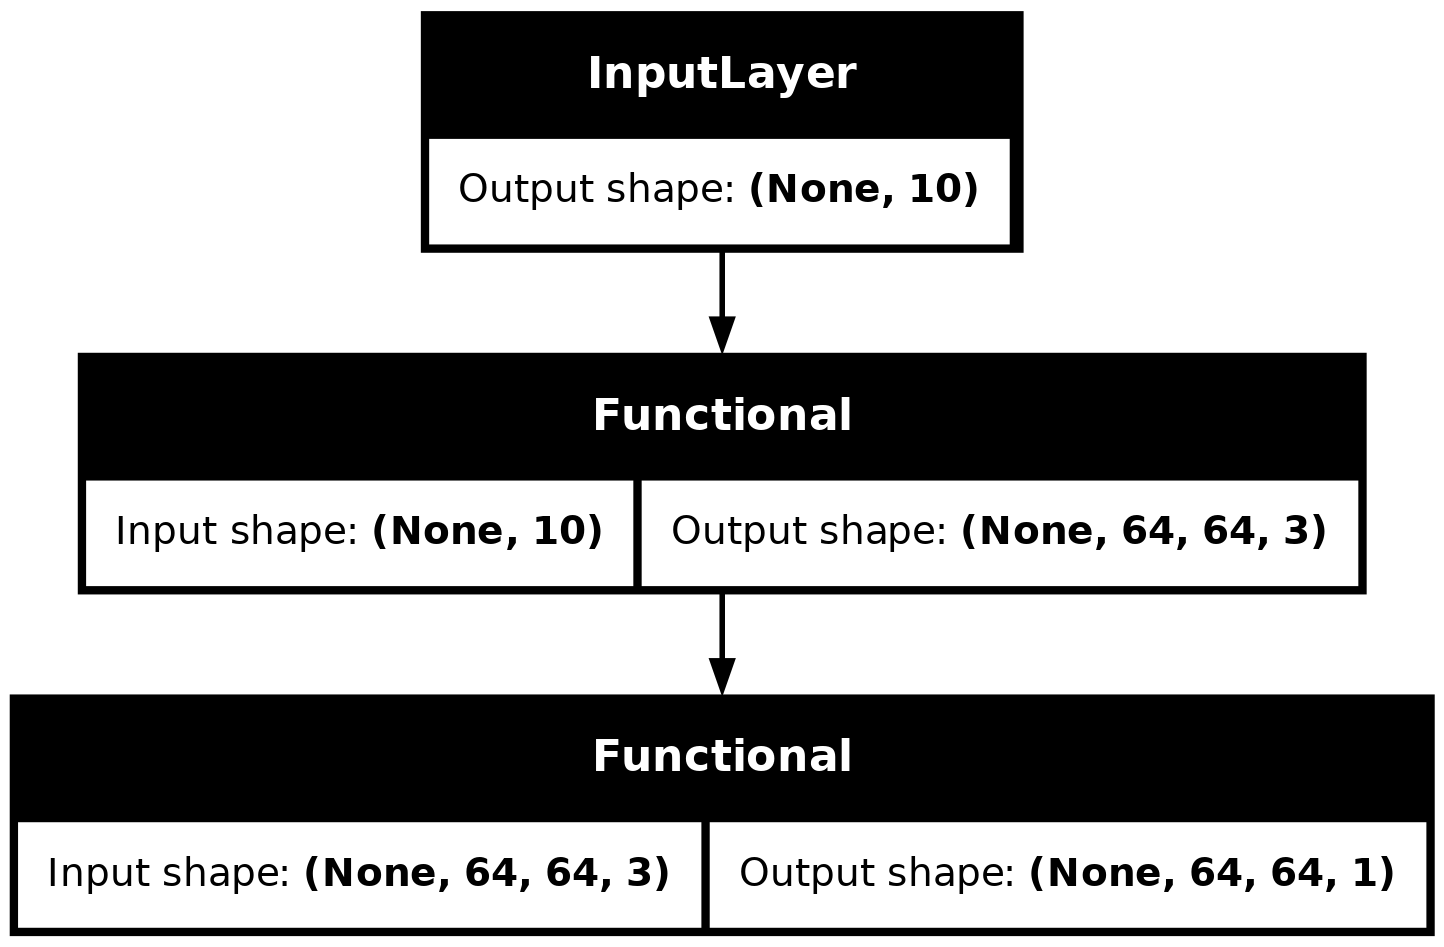

In [12]:
latent_dim = 10
image_shape = (64, 64, 3)
output_shape = (64, 64, 3)

# Build the Generator model
def build_generator(latent_dim, output_shape):
    generator_input = Input(shape=(latent_dim,))
    x = Dense(64)(generator_input)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)

    # Calculate the number of units in the Dense layer for the generator output
    num_units = output_shape[0] * output_shape[1] * output_shape[2]

    # Generator output with a Dense layer and reshape
    generated_data = Dense(num_units, activation='tanh')(x)
    generated_data = Reshape(output_shape)(generated_data)

    generator = Model(generator_input, generated_data)
    return generator

# Build the Discriminator model
def build_discriminator(input_shape):
    discriminator_input = Input(shape=input_shape)
    x = Dense(128)(discriminator_input)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    validity = Dense(1, activation='sigmoid')(x)
    discriminator = Model(discriminator_input, validity)
    return discriminator

# Build the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)
    gan = Model(gan_input, gan_output)
    return gan

generator = build_generator(latent_dim, output_shape)
discriminator = build_discriminator(output_shape)
gan = build_gan(generator, discriminator)

# Print the model summaries
generator.summary()
discriminator.summary()
gan.summary()

# Plot the model architectures
plot_model(generator, show_shapes=True, to_file="generator.png")
plot_model(discriminator, show_shapes=True, to_file="discriminator.png")
plot_model(gan, show_shapes=True, to_file="gan.png")

**Multimodal Fusion for Additional Modalities - Apply multimodal fusion on image data - RGB and GrayScale modalities**


In [13]:
def multimodal_fusion(images, num_modalities):
    num_samples, num_frames, height, width, channels = images.shape

    # Create additional modalities by converting images to grayscale
    additional_modalities = []
    for i in range(1, num_modalities):
        modified_images = []
        for frame in range(num_frames):
            grayscale_frame = np.mean(images[:, frame], axis=-1, keepdims=True)
            modified_images.append(grayscale_frame)
        additional_modalities.append(np.array(modified_images))

    # Tile the additional modalities to match the number of frames
    tiled_modalities = [modalities[:, np.newaxis] for modalities in additional_modalities]
    tiled_modalities = [np.tile(modalities, (1, num_frames, 1, 1, 1)) for modalities in tiled_modalities]

    # Concatenate the original images and additional modalities along the channel axis
    fused_data = np.concatenate((images, *tiled_modalities), axis=-1)
    return fused_data

**Create additional modalities**

In [14]:
batch_size = 40
num_modalities = 1 #Add GrayScale with RGB modality

# Load the data from the HDF5 file
h5_file = h5py.File('/kaggle/working/dataset/data.h5', 'r')
num_samples = len(h5_file['X_images_train'])
y_train = h5_file['y_train'][:]

multimodal_data = []

for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    batch_X_images_train = h5_file['X_images_train'][batch_start:batch_end]
    #batch_X_images_test = h5_file['X_images_test'][batch_start:batch_end]

    # Perform multimodal fusion on the current batch
    fused_batch_X_train = multimodal_fusion(batch_X_images_train, num_modalities)
    #fused_batch_X_test = multimodal_fusion(batch_X_images_test, num_modalities)
    multimodal_data.append(fused_batch_X_train)
    print("Fused batch X_train shape:", fused_batch_X_train.shape)
    #print("Fused batch X_test shape:", fused_batch_X_test.shape)

h5_file.close()

Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)


**Neural Architecture Search (NAS) Model - Create an image-based AutoKeras model and train it**

In [15]:
# Stack the multimodal data
fused_X_train = np.vstack(multimodal_data)

# Get the dimensions from the shape of fused_X_train
num_samples, num_frames, height, width, channels = fused_X_train.shape

# Reshape the data to match AutoKeras expected format
reshaped_X_train = fused_X_train.reshape((-1, height, width, channels))

# Reshape again to treat each frame as a separate sample
reshaped_X_train = reshaped_X_train.reshape((-1, height, width, channels))

# Reshape y_train to match the new number of samples
reshaped_y_train = np.repeat(y_train, num_frames, axis=0)

print("reshaped_X_train shape:", reshaped_X_train.shape)
print("reshaped_y_train shape:", reshaped_y_train.shape)

X_train, X_val, y_train, y_val = train_test_split(reshaped_X_train, reshaped_y_train, test_size=0.2, random_state=42)

# Create the image-based AutoKeras model
search = ak.ImageClassifier(max_trials=2)

# Train the NAS model
history = search.fit(reshaped_X_train, reshaped_y_train, epochs=4, validation_data=(X_val, y_val))
print(history.history.keys())

# Export the best model architecture
best_model = search.export_model()

Trial 2 Complete [00h 31m 50s]
val_loss: 0.7601763010025024

Best val_loss So Far: 0.2020881175994873
Total elapsed time: 00h 32m 27s
Epoch 1/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.4976 - loss: 1.3864 - val_accuracy: 0.7719 - val_loss: 0.6563
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.7473 - loss: 0.6408 - val_accuracy: 0.6719 - val_loss: 0.5333
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.8018 - loss: 0.5247 - val_accuracy: 0.8375 - val_loss: 0.3736
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.8168 - loss: 0.4262 - val_accuracy: 0.9094 - val_loss: 0.2555
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


**Save the best fit model and explore it**

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 64, 64, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        57,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1           │ (None, 1)              │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,000 (300.79 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 7 (32.00 B)

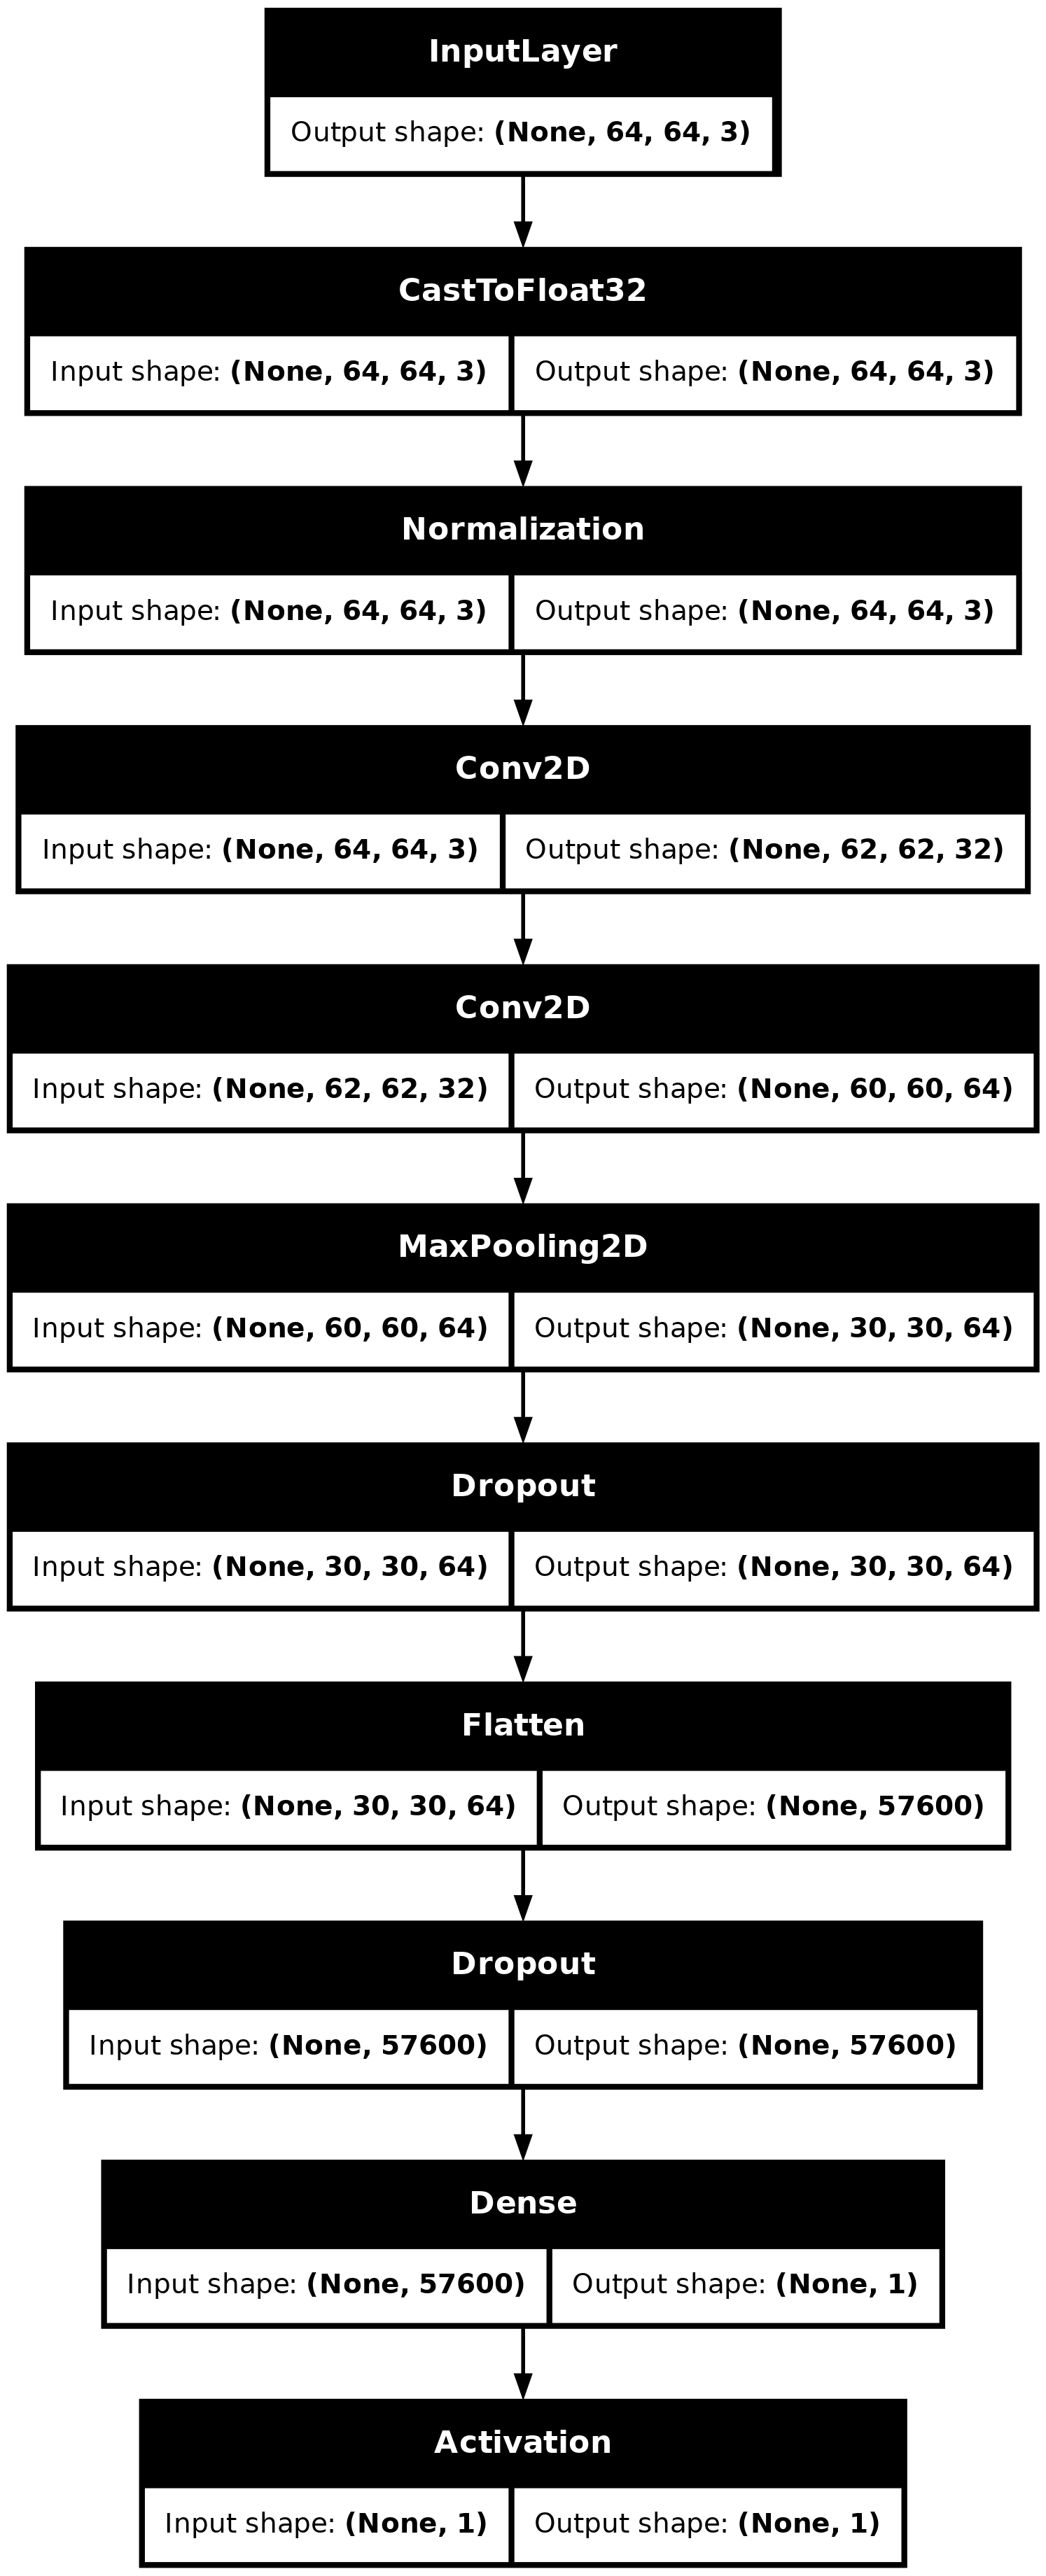

In [16]:
# Save the model
save_model(best_model, '/kaggle/working/best_model.h5')

# Print the model summary
best_model.summary()

# Plot the model architecture
plot_model(best_model, show_shapes=True, to_file="best_model.png")

* **Train the best model using the training set**
* **Evaluate it using the validation set**

In [17]:
# Compile the best model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.9113 - loss: 0.2062 - val_accuracy: 0.8906 - val_loss: 0.1909
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.9349 - loss: 0.1504 - val_accuracy: 0.8867 - val_loss: 0.1828
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.9262 - loss: 0.1271 - val_accuracy: 0.8945 - val_loss: 0.1733
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.9492 - loss: 0.0987 - val_accuracy: 0.8867 - val_loss: 0.2402
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9480 - loss: 0.1346 - val_accuracy: 0.9414 - val_loss: 0.1499
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9411 - loss: 0.1276 - val_accuracy: 0.9062 - val_loss: 0.2055
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9466 - loss: 0.1203 - val_accuracy: 0.9102 - val_loss: 0.2561
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9506 - loss: 0.1030 - val_accuracy

**Plot training history**

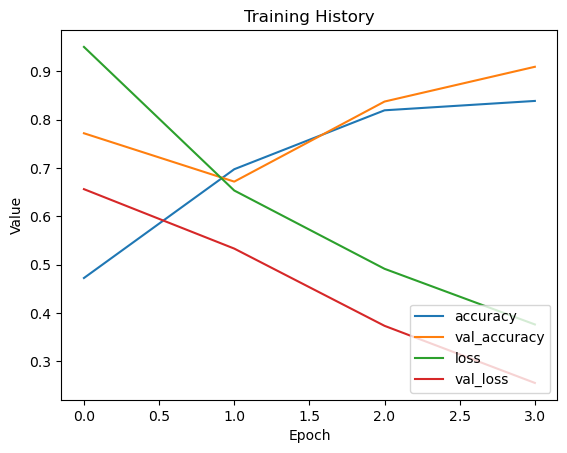

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('Training History')
plt.show()